## Import modules

In [8]:
%matplotlib inline
import argparse

import os
import random

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.parallel

import torch.utils.data

import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

from IPython.display import HTML

In [5]:
manual_seed = 999
random.seed(manual_seed)
torch.manual_seed(manual_seed)
torch.use_deterministic_algorithms(True)

## Mount drive

In [2]:
from google.colab import drive
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## Inputs

In [27]:
# Root directory for dataset
dataroot = "/content/gdrive/MyDrive/celeba_small"

# Number of workers for dataloader
workers = 2

# Batch size during training
batch_size = 64

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 64

# Number of channels in the training images. For color images this is 3
nc = 3

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Number of training epochs
num_epochs = 20

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparameter for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

## Data
For this project, I used the [Celeb-A Faces dataset](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) which can be downloaded at the linked site.

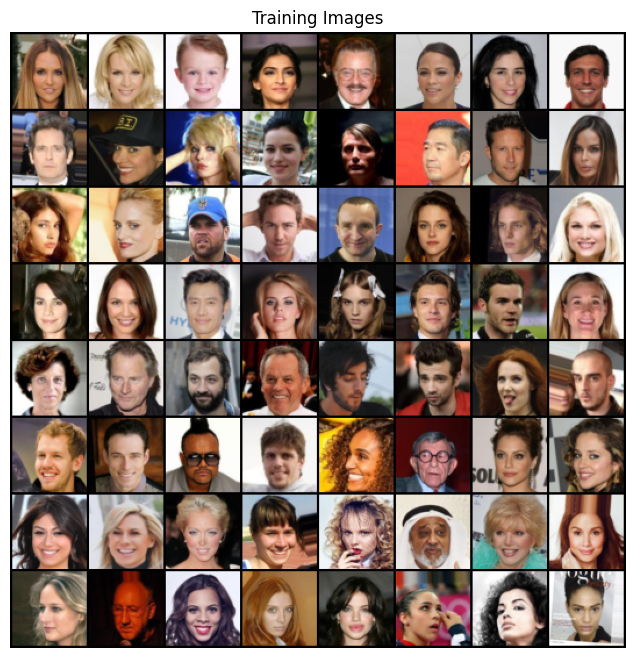

In [9]:
# Create the dataset
dataset = dset.ImageFolder(root=dataroot,
                          transform=transforms.Compose([
                              transforms.Resize(image_size),
                              transforms.CenterCrop(image_size),
                              transforms.ToTensor(),
                              transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                          ]))

# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                        shuffle=True,
                                        num_workers=workers)

# Decide device
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# Plot training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8, 8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2,
                                        normalize=True).cpu(), (1, 2, 0)))

## Weight Initialization

In [10]:
def weights_init(m):
    # 'm' represents a layer object
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1, 0.02)
        nn.init.constant(m.bias.data, 0)

## Generator
The generator, G, is designed to map the latent space vector (z) to data-space. Since my data is images, converting z to data-space means ultimately creating a RGB image with the same size as the training images (i.e. 3x64x64).

In [11]:
class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # Input is Z, going into the convolution
            nn.ConvTranspose2d(nz, ngf*8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf*8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4

            nn.ConvTranspose2d(ngf*8, ngf*4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf*4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8

            nn.ConvTranspose2d(ngf*4, ngf*2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf*2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16

            nn.ConvTranspose2d(ngf*2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32

            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        return self.main(input)

In [12]:
netG = Generator(ngpu).to(device)

if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

netG.apply(weights_init)

print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


<ipython-input-10-c47319d40ec4>:8: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.
  nn.init.constant(m.bias.data, 0)


## Discriminator

In [13]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32

            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16

            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8

            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4

            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [20]:
netD = Discriminator(ngpu).to(device)

if (device == "cuda") and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))

netD.apply(weights_init)

print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


<ipython-input-10-c47319d40ec4>:8: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.
  nn.init.constant(m.bias.data, 0)


## Loss function and Optimizers

In [21]:
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

real_label = 1
fake_label = 0

criterion = nn.BCELoss()

# optimizers
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

## Training Loop

In [28]:
G_losses = []
D_losses = []
img_list = []

print("starting the training loop...")

iters = 0
for epoch in range(num_epochs):
    for i, data in enumerate(dataloader, 0): # dataloader loads batches of images
        # To avoid accumulating gradients across diff. batches:
        netD.zero_grad()

        # =============================================================
        # Calculate error of DISCRIMINATOR - ON ALL REAL
        # =============================================================
        # Retreiving the batch of images
        real_cpu = data[0].to(device)
        # Assigning labels to the batch of images
        batch_size = real_cpu.size(0)
        label = torch.full((batch_size,), real_label,
                            dtype=torch.float,
                              device=device)
        # Forward pass batch through the discriminator
        output = netD(real_cpu).view(-1)
        # Average result of discriminator
        D_x = output.mean().item()
        # Calculate error on real batch
        errD_real = criterion(output, label)
        # Calculate gradients
        errD_real.backward()

        # =============================================================
        # Calculate error of DISCRIMINATOR - ON ALL FAKE
        # =============================================================
        # For each fake image to be generated, make a noise vector
        noise = torch.randn(batch_size, nz, 1, 1, device=device)
        # Generate fake images
        fake = netG(noise)
        # Assigning labels to the batch of fake
        label.fill_(fake_label)
        # Forward pass batch through the discriminator
        output = netD(fake.detach()).view(-1)
        # Average result of discriminator
        D_G_z1 = output.mean().item()
        # Error on fake batch
        errD_fake = criterion(output, label)
        # Calculate gradients - Accumulates these on top of the one calculated before[for real batch]
        errD_fake.backward()

        # Total loss
        errD = errD_real + errD_fake

        # UPDATING THE DISCRIMINATOR - Applying the gradients
        optimizerD.step()

        # ==============================================================
        # UPDATE GENRATOR
        # ==============================================================
        netG.zero_grad()

        label.fill_(real_label)
        output = netD(fake).view(-1)
        D_G_z2 = output.mean().item()
        errG = criterion(output, label)
        errG.backward()
        optimizerG.step()

       # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))


        # Save Losses for plotting
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 10 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():  # to not keep track of the unnecessary gradients
                fake = netG(fixed_noise).detach().cpu()  # detach the tensor from it's computation graph-so we can't use 'fake' tensor to update weights of the netG
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

starting the training loop...
[0/20][0/22]	Loss_D: 0.6383	Loss_G: 3.0989	D(x): 0.8291	D(G(z)): 0.2718 / 0.0781
[1/20][0/22]	Loss_D: 0.8668	Loss_G: 4.0515	D(x): 0.8213	D(G(z)): 0.4295 / 0.0306
[2/20][0/22]	Loss_D: 0.7515	Loss_G: 6.1011	D(x): 0.9408	D(G(z)): 0.4444 / 0.0058
[3/20][0/22]	Loss_D: 0.3986	Loss_G: 4.0432	D(x): 0.8755	D(G(z)): 0.2014 / 0.0281
[4/20][0/22]	Loss_D: 0.6690	Loss_G: 5.4067	D(x): 0.8648	D(G(z)): 0.3509 / 0.0114
[5/20][0/22]	Loss_D: 1.0243	Loss_G: 8.3096	D(x): 0.8983	D(G(z)): 0.4976 / 0.0008
[6/20][0/22]	Loss_D: 0.4987	Loss_G: 3.6872	D(x): 0.7792	D(G(z)): 0.1627 / 0.0351
[7/20][0/22]	Loss_D: 0.5138	Loss_G: 4.4125	D(x): 0.7909	D(G(z)): 0.1544 / 0.0202
[8/20][0/22]	Loss_D: 1.2266	Loss_G: 5.0083	D(x): 0.4462	D(G(z)): 0.0114 / 0.0177
[9/20][0/22]	Loss_D: 1.0036	Loss_G: 5.5980	D(x): 0.8156	D(G(z)): 0.4615 / 0.0103
[10/20][0/22]	Loss_D: 1.2183	Loss_G: 4.9326	D(x): 0.4365	D(G(z)): 0.0058 / 0.0293
[11/20][0/22]	Loss_D: 0.3311	Loss_G: 3.7479	D(x): 0.8464	D(G(z)): 0.0956 / 0.0

## Results

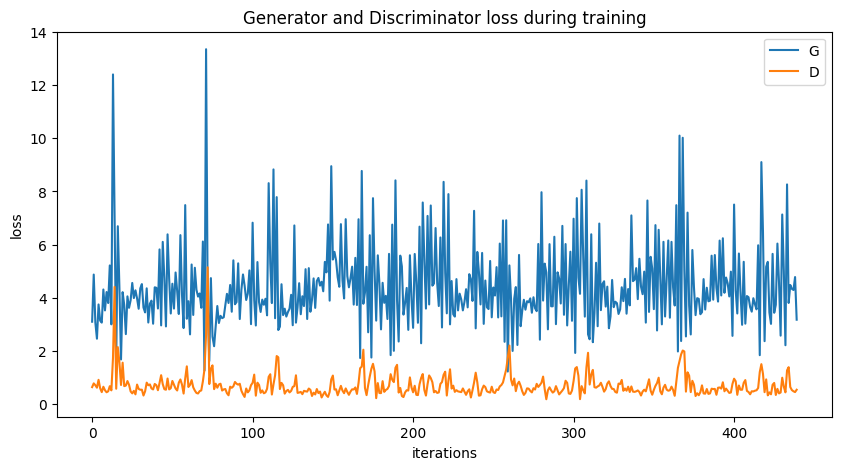

In [29]:
plt.figure(figsize=(10, 5))
plt.title("Generator and Discriminator loss during training")
plt.plot(G_losses, label="G")
plt.plot(D_losses, label="D")
plt.xlabel("iterations")
plt.ylabel("loss")
plt.legend()
plt.show()

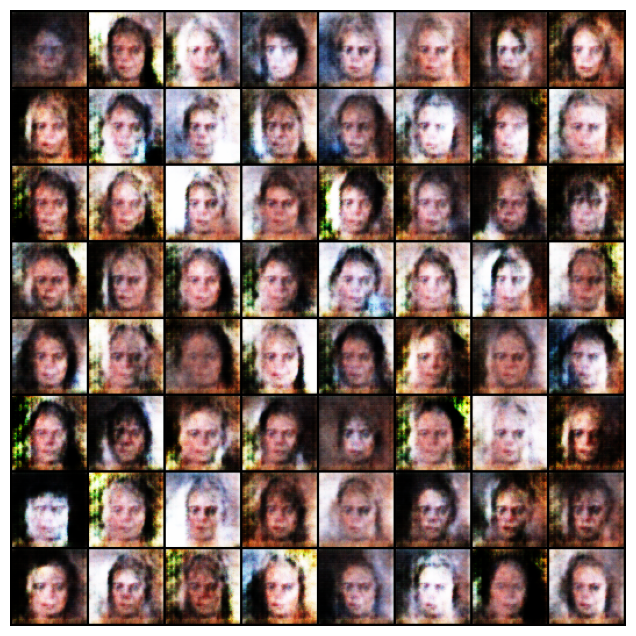

In [30]:
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

## Plotting real and fake images side by side

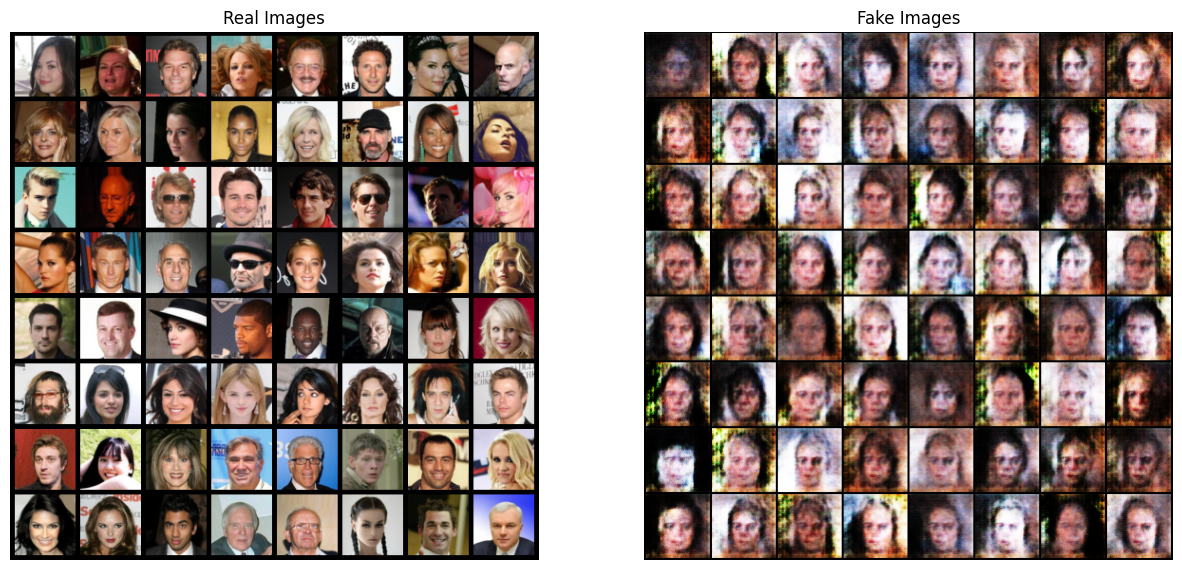

In [31]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()